In [55]:
from IPython.display import Audio
from ipywebrtc import AudioRecorder, CameraStream
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from custom_metrics import f1_m, precision_m, recall_m
from utils import get_commands

<h2>Helper methods</h2>

Methods to read in audio as tensor to be able make prediction on it.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
commands = get_commands("../data/mini_speech_commands")


def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]


def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)


def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label


def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(equal_length,
                                 frame_length=255,
                                 frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.math.argmax(label == commands)
    return spectrogram, label_id


def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label,
                             num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id,
                              num_parallel_calls=AUTOTUNE)
    return output_ds

<h2>Load model</h2>

Load trained model from disk

In [57]:
trained_model = tf.keras.models.load_model('../model',
                                           custom_objects={
                                               "f1_m": f1_m,
                                               "precision_m": precision_m,
                                               "recall_m": recall_m
                                           })
trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0


<h2>Load in self spoken sample</h2>

/tmp/ipykernel_3581269/2157620719.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.title(f"Predictions {commands[label]}")


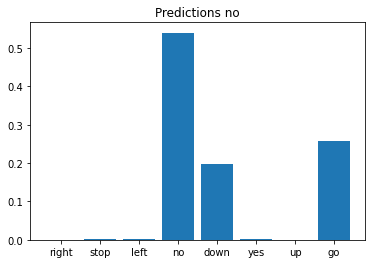

In [70]:
sample_file = '../custom_data/commands/no/no.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = trained_model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f"Predictions {commands[label]}")
    plt.show()

In [71]:
Audio(sample_file, rate=16000)